# Import data from S3 Bucket

In [1]:
# !aws configure

In [2]:
# !aws s3 sync s3://victor-medical-ai-chest-xray/train/ ./data/train/ --no-progress --only-show-errors

In [3]:
# !aws s3 sync s3://victor-medical-ai-chest-xray/test/ ./data/test/ --no-progress --only-show-errors

# Train, Hyperparameter Search, and Fine-Tune a ResNet model

Run notebook if you have single GPU

For multi-gpu support:

- python train.py


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import optuna
import gc
import pathlib, shutil

In [5]:
# # ── 0. Reorganize Data Folder ───────────────────────────────────────
# base = pathlib.Path("data/train")
# for fname in base.iterdir():
#     if not fname.is_file(): 
#         continue
#     label = "NORMAL" if "normal" in fname.name.lower() else "PNEUMONIA"
#     dest = base / label
#     dest.mkdir(exist_ok=True)
#     shutil.move(str(fname), str(dest / fname.name))

In [6]:
# base = pathlib.Path("data/test")
# for fname in base.iterdir():
#     if not fname.is_file(): 
#         continue
#     label = "NORMAL" if "normal" in fname.name.lower() else "PNEUMONIA"
#     dest = base / label
#     dest.mkdir(exist_ok=True)
#     shutil.move(str(fname), str(dest / fname.name))

In [7]:
# ── 1. Data augmentation & preprocessing ───────────────────────────────────────
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),       # crop
    transforms.RandomHorizontalFlip(),       # flip
    transforms.ColorJitter(0.4,0.4,0.4,0.1), # color
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std) # **normalization**
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [8]:
# ── 2. Train the model and find best parameter using optuna ───────────────────────────────────────
def validate_model(model, val_loader, criterion):
    """Validate the model and return accuracy and loss"""
    model.eval()
    correct = total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item()
            
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
    accuracy = correct / total
    avg_loss = running_loss / len(val_loader)
    return accuracy, avg_loss

In [9]:
def objective(trial):
    # 0) Suggest hyper-parameters
    lr = trial.suggest_float("lr", 0.01, 0.1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    
    # Make scheduler milestones adaptive to hyperparameters
    milestone1 = trial.suggest_int("milestone1", 15, 35)
    milestone2 = trial.suggest_int("milestone2", milestone1 + 5, 45)
    gamma = trial.suggest_float("gamma", 0.05, 0.3)
    
    # Early stopping parameters
    patience = trial.suggest_int("patience", 5, 15)
    validation_freq = trial.suggest_int("validation_freq", 3, 8)
    
    print(f"\n--- Trial {trial.number} ---")
    print(f"LR: {lr:.6f}, Batch: {batch_size}, Optimizer: {optimizer_name}")
    print(f"Weight decay: {weight_decay:.6f}, Milestones: [{milestone1}, {milestone2}]")
    print(f"Patience: {patience}, Validation freq: {validation_freq}")
    
    try:
        # 1) DataLoaders
        train_loader = DataLoader(
            datasets.ImageFolder("data/train", transform=train_tfms),
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
        )
        val_loader = DataLoader(
            datasets.ImageFolder("data/test", transform=val_tfms),
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )
        
        # 2) Build model and wrap for multi‐GPU
        model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
        model.fc = nn.Linear(model.fc.in_features, 2)
        if DEVICE.startswith("cuda") and torch.cuda.device_count() > 1:
            print(f"→ Using {torch.cuda.device_count()} GPUs via DataParallel")
            model = nn.DataParallel(model)
        model = model.to(DEVICE)
        
        # 3) Optimizer / scheduler / loss
        if optimizer_name == "adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        else:
            optimizer = optim.SGD(model.parameters(), lr=lr,
                                  weight_decay=weight_decay, momentum=0.9)
        
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[milestone1, milestone2], gamma=gamma
        )
        criterion = nn.CrossEntropyLoss()
        
        # 4) Training loop with early stopping
        best_acc = 0.0
        patience_counter = 0
        
        for epoch in range(1, 21):  # Increased max epochs since we have early stopping
            model.train()
            running_loss = 0.0
            
            for batch_idx, (x, y) in enumerate(train_loader):
                x, y = x.to(DEVICE), y.to(DEVICE)
                optimizer.zero_grad()
                loss = criterion(model(x), y)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            scheduler.step()
            
            # Periodic validation
            if epoch % validation_freq == 0:
                val_acc, val_loss = validate_model(model, val_loader, criterion)
                train_loss = running_loss / len(train_loader)
                
                print(f"Epoch {epoch:2d}: Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                
                # Early stopping logic
                if val_acc > best_acc:
                    best_acc = val_acc
                    patience_counter = 0
                    print(f"  → New best accuracy: {best_acc:.4f}")
                else:
                    patience_counter += 1
                    print(f"  → No improvement ({patience_counter}/{patience})")
                
                # Stop if no improvement for 'patience' validation checks
                if patience_counter >= patience:
                    print(f"  → Early stopping at epoch {epoch}")
                    break
                
                # Pruning for Optuna (optional)
                trial.report(val_acc, epoch)
                if trial.should_prune():
                    print(f"  → Trial pruned at epoch {epoch}")
                    raise optuna.exceptions.TrialPruned()
        
        # 5) Final validation if we didn't validate in the last epoch
        if epoch % validation_freq != 0:
            final_acc, _ = validate_model(model, val_loader, criterion)
            best_acc = max(best_acc, final_acc)
        
        print(f"Trial {trial.number} completed with best accuracy: {best_acc:.4f}")
        
        return best_acc
    
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        return 0.0
    
    finally:
        # 6) Memory cleanup
        if 'model' in locals():
            del model
        if 'train_loader' in locals():
            del train_loader
        if 'val_loader' in locals():
            del val_loader
        if 'optimizer' in locals():
            del optimizer
        if 'scheduler' in locals():
            del scheduler
        
        # Force garbage collection and clear GPU cache
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

In [10]:
# ── 3. Run the optimization ───────────────────────────────────────
def run_optimization(n_trials=20):
    # Create study with pruning
    study = optuna.create_study(
        direction="maximize",
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
    )
    
    print(f"Starting optimization with {n_trials} trials...")
    study.optimize(objective, n_trials=n_trials)
    
    print("\n" + "="*50)
    print("OPTIMIZATION COMPLETED")
    print("="*50)
    print(f"Best trial: {study.best_trial.number}")
    print(f"Best accuracy: {study.best_value:.4f}")
    print("Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    return study

In [11]:
# Run the optimization (uncomment to run)
study = run_optimization(n_trials=20)

[I 2025-06-20 20:27:26,386] A new study created in memory with name: no-name-7c5af09b-1a05-4bde-b5be-cc2a3fd15e94


Starting optimization with 20 trials...

--- Trial 0 ---
LR: 0.046628, Batch: 64, Optimizer: sgd
Weight decay: 0.000002, Milestones: [33, 39]
Patience: 11, Validation freq: 3
→ Using 7 GPUs via DataParallel
Epoch  3: Train Loss: 1.1104, Val Loss: 0.7160, Val Acc: 0.5929
  → New best accuracy: 0.5929
Epoch  6: Train Loss: 0.5856, Val Loss: 0.7190, Val Acc: 0.6250
  → New best accuracy: 0.6250
Epoch  9: Train Loss: 0.5033, Val Loss: 0.4964, Val Acc: 0.7196
  → New best accuracy: 0.7196
Epoch 12: Train Loss: 0.4518, Val Loss: 0.5903, Val Acc: 0.6763
  → No improvement (1/11)
Epoch 15: Train Loss: 0.4282, Val Loss: 0.3781, Val Acc: 0.8429
  → New best accuracy: 0.8429
Epoch 18: Train Loss: 0.3616, Val Loss: 0.8312, Val Acc: 0.6522
  → No improvement (1/11)
Trial 0 completed with best accuracy: 0.8702


[I 2025-06-20 20:31:09,535] Trial 0 finished with value: 0.8701923076923077 and parameters: {'lr': 0.04662755029428757, 'batch_size': 64, 'optimizer': 'sgd', 'weight_decay': 2.2906885183966685e-06, 'milestone1': 33, 'milestone2': 39, 'gamma': 0.12371688061647655, 'patience': 11, 'validation_freq': 3}. Best is trial 0 with value: 0.8701923076923077.



--- Trial 1 ---
LR: 0.024765, Batch: 64, Optimizer: adam
Weight decay: 0.000019, Milestones: [20, 44]
Patience: 10, Validation freq: 3
→ Using 7 GPUs via DataParallel
Epoch  3: Train Loss: 0.5288, Val Loss: 0.4550, Val Acc: 0.7853
  → New best accuracy: 0.7853
Epoch  6: Train Loss: 0.4395, Val Loss: 0.4530, Val Acc: 0.8237
  → New best accuracy: 0.8237
Epoch  9: Train Loss: 0.4281, Val Loss: 0.4610, Val Acc: 0.7869
  → No improvement (1/10)
Epoch 12: Train Loss: 0.3887, Val Loss: 1.0008, Val Acc: 0.6122
  → No improvement (2/10)
Epoch 15: Train Loss: 0.3959, Val Loss: 0.4272, Val Acc: 0.7933
  → No improvement (3/10)
Epoch 18: Train Loss: 0.3895, Val Loss: 0.3850, Val Acc: 0.8157
  → No improvement (4/10)
Trial 1 completed with best accuracy: 0.8237


[I 2025-06-20 20:35:04,953] Trial 1 finished with value: 0.8237179487179487 and parameters: {'lr': 0.024764580123320168, 'batch_size': 64, 'optimizer': 'adam', 'weight_decay': 1.8989894996116573e-05, 'milestone1': 20, 'milestone2': 44, 'gamma': 0.23016894556205386, 'patience': 10, 'validation_freq': 3}. Best is trial 0 with value: 0.8701923076923077.



--- Trial 2 ---
LR: 0.014360, Batch: 16, Optimizer: sgd
Weight decay: 0.000018, Milestones: [20, 31]
Patience: 14, Validation freq: 8
→ Using 7 GPUs via DataParallel
Epoch  8: Train Loss: 0.2515, Val Loss: 0.1564, Val Acc: 0.9327
  → New best accuracy: 0.9327
Epoch 16: Train Loss: 0.1857, Val Loss: 0.3456, Val Acc: 0.9247
  → No improvement (1/14)


[I 2025-06-20 20:45:53,494] Trial 2 finished with value: 0.9391025641025641 and parameters: {'lr': 0.014360209215074127, 'batch_size': 16, 'optimizer': 'sgd', 'weight_decay': 1.827453601711337e-05, 'milestone1': 20, 'milestone2': 31, 'gamma': 0.2046293167521604, 'patience': 14, 'validation_freq': 8}. Best is trial 2 with value: 0.9391025641025641.


Trial 2 completed with best accuracy: 0.9391

--- Trial 3 ---
LR: 0.050086, Batch: 64, Optimizer: adam
Weight decay: 0.000002, Milestones: [23, 30]
Patience: 11, Validation freq: 8
→ Using 7 GPUs via DataParallel
Epoch  8: Train Loss: 0.4527, Val Loss: 0.7545, Val Acc: 0.5096
  → New best accuracy: 0.5096
Epoch 16: Train Loss: 0.3608, Val Loss: 0.3993, Val Acc: 0.8381
  → New best accuracy: 0.8381
Trial 3 completed with best accuracy: 0.8782


[I 2025-06-20 20:49:48,652] Trial 3 finished with value: 0.8782051282051282 and parameters: {'lr': 0.05008649803407198, 'batch_size': 64, 'optimizer': 'adam', 'weight_decay': 1.6362183810429907e-06, 'milestone1': 23, 'milestone2': 30, 'gamma': 0.29983325383632986, 'patience': 11, 'validation_freq': 8}. Best is trial 2 with value: 0.9391025641025641.



--- Trial 4 ---
LR: 0.030270, Batch: 32, Optimizer: adam
Weight decay: 0.003946, Milestones: [25, 35]
Patience: 6, Validation freq: 7
→ Using 7 GPUs via DataParallel
Epoch  7: Train Loss: 0.5686, Val Loss: 0.6631, Val Acc: 0.6250
  → New best accuracy: 0.6250
Epoch 14: Train Loss: 0.5655, Val Loss: 0.6570, Val Acc: 0.6250
  → No improvement (1/6)


[I 2025-06-20 20:56:23,731] Trial 4 finished with value: 0.625 and parameters: {'lr': 0.030270072735319658, 'batch_size': 32, 'optimizer': 'adam', 'weight_decay': 0.003946309705607039, 'milestone1': 25, 'milestone2': 35, 'gamma': 0.0740068740475442, 'patience': 6, 'validation_freq': 7}. Best is trial 2 with value: 0.9391025641025641.


Trial 4 completed with best accuracy: 0.6250

--- Trial 5 ---
LR: 0.016770, Batch: 16, Optimizer: adam
Weight decay: 0.000102, Milestones: [18, 33]
Patience: 9, Validation freq: 5
→ Using 7 GPUs via DataParallel
Epoch  5: Train Loss: 0.5584, Val Loss: 0.6625, Val Acc: 0.6250
  → New best accuracy: 0.6250


In [ ]:
# Summary of all trials
print("\n=== Trial results ===")
for t in study.trials:
    if t.value is not None:  # Skip failed/pruned trials
        print(f"• Trial {t.number:2d}: val_acc={t.value:.4f}, params={t.params}")
    else:
        print(f"• Trial {t.number:2d}: FAILED/PRUNED")
        
print(f"\nBest validation accuracy: {study.best_value:.4f}")
print("Best hyper-parameters:")
for k, v in study.best_params.items():
    print(f"  • {k} = {v}")

# Retrain model with best parameter

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# ── 1) Pull ALL best params from Optuna study ────────────
best = study.best_params
print(f"\nRetraining with best parameters: {best}")

lr = best["lr"]
batch_size = best["batch_size"]
optimizer_name = best["optimizer"]
weight_decay = best["weight_decay"]

# Use the optimized scheduler parameters if they exist
milestone1 = best.get("milestone1", 30)  # fallback to 30 if not found
milestone2 = best.get("milestone2", 40)  # fallback to 40 if not found
gamma = best.get("gamma", 0.1)           # fallback to 0.1 if not found
patience_epochs = best.get("patience", 5) * best.get("validation_freq", 5)  # Convert to epochs

print(f"Scheduler milestones: [{milestone1}, {milestone2}], gamma: {gamma}")
print(f"Early stopping patience: {patience_epochs} epochs")


In [ ]:
# ── 2) Transforms (same as before) ────────────────────────
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
# ── 3) DataLoaders ────────────────────────────────────────
train_ds = datasets.ImageFolder("data/train", transform=train_tfms)
val_ds = datasets.ImageFolder("data/test", transform=val_tfms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

In [ ]:
# ── 4) Model & optimizer setup ────────────────────────────
model = torchvision.models.resnet18(weights="IMAGENET1K_V1")
model.fc = nn.Linear(model.fc.in_features, 2)

# Add multi-GPU support if available
if device.startswith("cuda") and torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs via DataParallel")
    model = nn.DataParallel(model)

model = model.to(device)

# Create optimizer with best parameters
if optimizer_name == "adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
else:
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)

# Use optimized scheduler parameters
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[milestone1, milestone2], gamma=gamma)
criterion = nn.CrossEntropyLoss()

In [ ]:
# ── 5) Full training loop with validation tracking ─────────────────────────
def validate_model(model, val_loader, criterion, device):
    """Validate model and return accuracy and loss"""
    model.eval()
    correct = total = 0
    running_loss = 0.0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            running_loss += loss.item()
            
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    
    accuracy = correct / total
    avg_loss = running_loss / len(val_loader)
    return accuracy, avg_loss

# Training loop
best_acc = 0.0
patience_counter = 0
train_losses = []
val_losses = []
val_accuracies = []

print(f"\nStarting training for up to 100 epochs...")
print(f"Early stopping patience: {patience_epochs} epochs")
print("-" * 60)

for epoch in range(1, 101):  # Increased max epochs
    # Training phase
    model.train()
    running_loss = 0.0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    scheduler.step()
    
    # Validation phase
    val_acc, val_loss = validate_model(model, val_loader, criterion, device)
    train_loss = running_loss / len(train_loader)
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")
    
    # Checkpoint saving and early stopping
    if val_acc > best_acc:
        best_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_acc': best_acc,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'best_params': best
        }, "best_model.pth")
        print(f"         → New best model saved! Accuracy: {best_acc:.4f}")
    else:
        patience_counter += 1
    
    # Early stopping check
    if patience_counter >= patience_epochs:
        print(f"\nEarly stopping triggered after {patience_counter} epochs without improvement")
        print(f"Best validation accuracy: {best_acc:.4f}")
        break

print("-" * 60)
print(f"Training completed!")
print(f"Best validation accuracy: {best_acc:.4f}")
print(f"Total epochs trained: {epoch}")
print(f"Model saved as 'best_model.pth'")

In [ ]:
# ── 6) Final model evaluation ────────────────────────────
print(f"\nFinal model performance:")
print(f"Best validation accuracy: {best_acc:.4f}")

# Load the best model for final evaluation
checkpoint = torch.load("best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
final_acc, final_loss = validate_model(model, val_loader, criterion, device)
print(f"Final model accuracy: {final_acc:.4f}")
print(f"Final model loss: {final_loss:.4f}")

# Plot training curves
try:
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss curves
    epochs_range = range(1, len(train_losses) + 1)
    ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy curve
    ax2.plot(epochs_range, val_accuracies, 'g-', label='Validation Accuracy')
    ax2.axhline(y=best_acc, color='r', linestyle='--', label=f'Best Acc: {best_acc:.4f}')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
except ImportError:
    print("Matplotlib not available. Skipping plots.")

print(f"\nTraining curves saved as 'training_curves.png'")

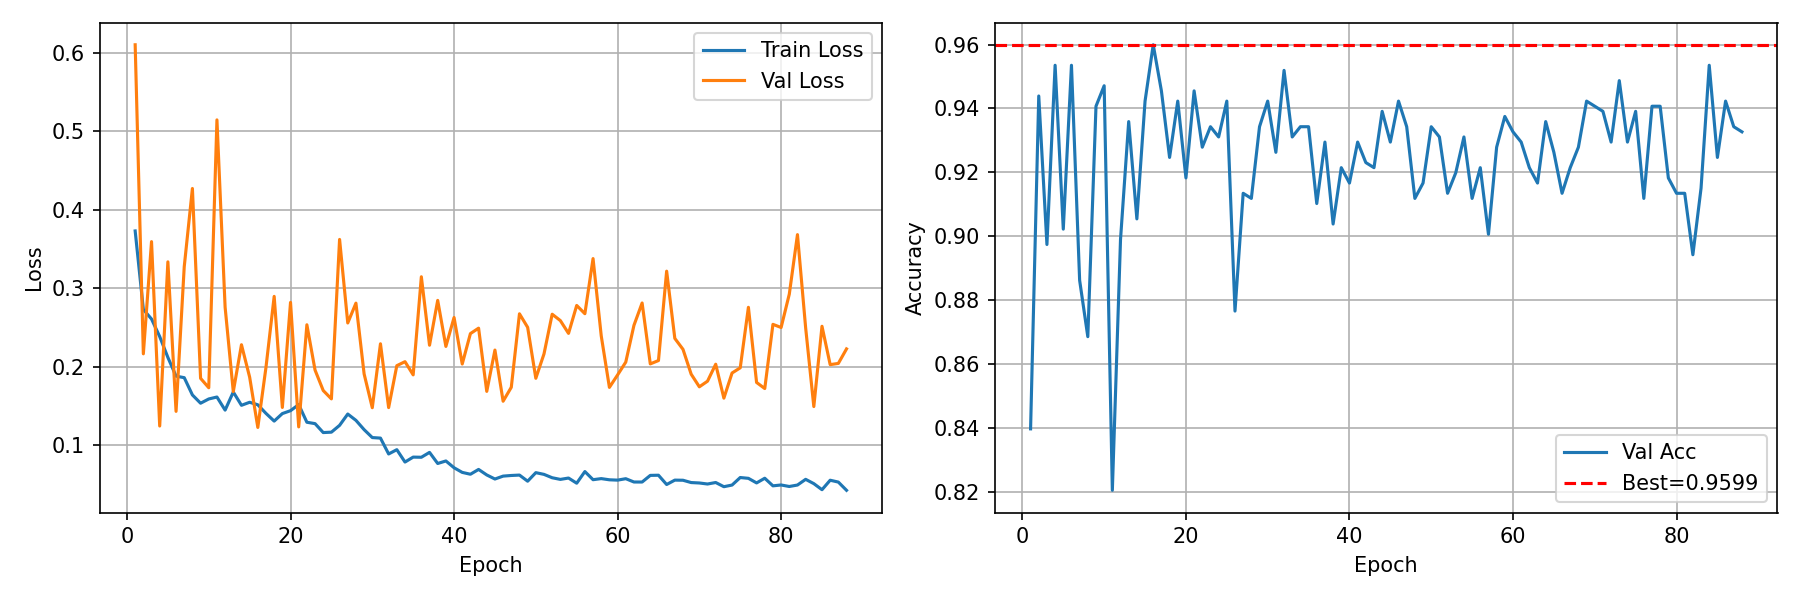

In [3]:
import json, requests, pprint

resp = requests.post(
    "https://lqq6925iw1.execute-api.us-east-1.amazonaws.com/production/predict-pneumonia",
    headers={"Content-Type": "application/x-image"},
    data=open("person1946_bacteria_4874.jpeg", "rb")
)

# ── envelope from API Gateway / Lambda ──────────
envelope = resp.json()          # {'statusCode': 200, 'headers': {...}, 'body': '{"message": "..."}'}

# ── actual model response inside `body` ─────────
payload  = json.loads(envelope["body"])   # {'message': 'Pneumonia detected (p=0.9969)'}
payload

{'message': 'Pneumonia detected (p=0.9969)'}